In [1]:
import os
import zipfile
import pandas as pd

In [2]:
source = "/content/drive/MyDrive/Florence2/Prescription Dataset.zip"
distination = "/content/drive/MyDrive/Florence2/Prescription"
os.makedirs(distination, exist_ok=True)

In [3]:
with zipfile.ZipFile(source, 'r') as zip_file:
  zip_file.extractall(distination)

In [4]:
annotate_data = pd.read_csv("/content/drive/MyDrive/Florence2/Prescription/Prescription Dataset/annotations.csv")
annotate_data.head()

,filename,label
0,From Bipin (1).png,Im mixtard 30/70
1,From Bipin (10).png,Tab- domperidone (10mg)
2,From Bipin (100).png,Tab. Ibuprofen 400mg
3,From Bipin (101).png,Tab. amlodipine 50mg
4,From Bipin (102).png,Napa


In [5]:
annotate_data = annotate_data.rename(columns={"filename":"image", "label":"answers"})

In [6]:
annotate_data.head()

,image,answers
0,From Bipin (1).png,Im mixtard 30/70
1,From Bipin (10).png,Tab- domperidone (10mg)
2,From Bipin (100).png,Tab. Ibuprofen 400mg
3,From Bipin (101).png,Tab. amlodipine 50mg
4,From Bipin (102).png,Napa


In [7]:
annotate_data["question"]="Extract the text from the image"

In [8]:
annotate_data.head()

,image,answers,question
0,From Bipin (1).png,Im mixtard 30/70,Extract the text from the image
1,From Bipin (10).png,Tab- domperidone (10mg),Extract the text from the image
2,From Bipin (100).png,Tab. Ibuprofen 400mg,Extract the text from the image
3,From Bipin (101).png,Tab. amlodipine 50mg,Extract the text from the image
4,From Bipin (102).png,Napa,Extract the text from the image


In [9]:
path = "/content/drive/MyDrive/Florence2/Prescription/Prescription Dataset/Nazmul/"

In [10]:
annotate_data["image"] = annotate_data["image"].apply(lambda x: path + x)
annotate_data.head()

,image,answers,question
0,/content/drive/MyDrive/Florence2/Prescription/...,Im mixtard 30/70,Extract the text from the image
1,/content/drive/MyDrive/Florence2/Prescription/...,Tab- domperidone (10mg),Extract the text from the image
2,/content/drive/MyDrive/Florence2/Prescription/...,Tab. Ibuprofen 400mg,Extract the text from the image
3,/content/drive/MyDrive/Florence2/Prescription/...,Tab. amlodipine 50mg,Extract the text from the image
4,/content/drive/MyDrive/Florence2/Prescription/...,Napa,Extract the text from the image


In [3]:
!pip install datasets flash_attn timm einops transformers pillow huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.10

In [12]:
from datasets import load_dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)
from torch.utils.data import Dataset
# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split


In [13]:
# 1. Configuration
data = annotate_data.copy()

In [14]:
# Split the data into training+validation and test sets
train, valid = train_test_split(data, test_size=0.2, random_state=42)

# Split the training+validation data into training and validation sets
# train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [15]:
train.shape

(335, 3)

In [16]:
valid.shape

(84, 3)

In [17]:
# test.shape

In [18]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
# test = test.reset_index(drop=True)

In [19]:
# !pip install datasets
from datasets import Dataset

In [20]:
# Create a datasets.Dataset object
train = Dataset.from_pandas(train) # train is already a Pandas DataFrame
valid = Dataset.from_pandas(valid) # valid is already a Pandas DataFrame
# test = Dataset.from_pandas(test) # test is already a Pandas DataFrame
# Print the dataset to check the format
print("Train Dataset : ", train)
print("Validation Dataset : ", valid)
# print("Test Dataset : ", test)

Train Dataset :  Dataset({
    features: ['image', 'answers', 'question'],
    num_rows: 335
})
Validation Dataset :  Dataset({
    features: ['image', 'answers', 'question'],
    num_rows: 84
})


In [21]:
# Create a DatasetDict object
data = DatasetDict({
    'train': train,
    'validation': valid #,
    # 'test': test
})

In [22]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'answers', 'question'],
        num_rows: 335
    })
    validation: Dataset({
        features: ['image', 'answers', 'question'],
        num_rows: 84
    })
})

In [23]:
# !pip install -U bitsandbytes

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
bnb_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)  # 4 bit quantization utilized

# base_model = AutoModelForCausalLM.from_pretrained(
#   pretrained_model_name_or_path="Siddharthvij10/MistralSharded2",

# )

In [25]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [35]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


In [36]:
# Assuming data is a datasets.DatasetDict object
for idx in range(3):
  # Accessing individual image from the list
  image_path = data['train']['image'][idx]
  # Load the image using PIL
  from PIL import Image
  image = Image.open(image_path)
  print(image)
  print( run_example("Extract the text from the Image", '', image))

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=267x65 at 0x7ED4213C5180>
{'Extract the text from the Image': 'yes'}
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=339x68 at 0x7ED4201078B0>
{'Extract the text from the Image': 'tab'}
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=134x69 at 0x7ED4201055A0>
{'Extract the text from the Image': '3 Alhamel'}


In [37]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = example['question']
        first_answer = example['answers']
        image = example['image']
        image = Image.open(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image

# Create datasets
train_dataset = DocVQADataset(data['train'])
val_dataset = DocVQADataset(data['validation'])

In [38]:
train_dataset

In [39]:
# Convert to Embeddings
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

batch_size = 1
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

In [43]:
# 4. Training Model
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
      model.train()
      train_loss = 0
      i = -1
      for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
          i += 1
          inputs, answers = batch

          input_ids = inputs["input_ids"]
          pixel_values = inputs["pixel_values"]
          # Ensure answers are a list of strings
          labels = processor.tokenizer(text=[str(answer) for answer in answers], return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

          outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
          loss = outputs.loss

          loss.backward()
          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()

          train_loss += loss.item()

      avg_train_loss = train_loss / len(train_loader)
      print(f"Average Training Loss: {avg_train_loss}")

      # Validation phase
      model.eval()
      val_loss = 0
      with torch.no_grad():
          for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
              inputs, answers = batch

              input_ids = inputs["input_ids"]
              pixel_values = inputs["pixel_values"]
              # Ensure answers are a list of strings
              labels = processor.tokenizer(text=[str(answer) for answer in answers], return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

              outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
              loss = outputs.loss

              val_loss += loss.item()

      avg_val_loss = val_loss / len(val_loader)
      print(f"Average Validation Loss: {avg_val_loss}")

    # Save model checkpoint
    output_dir = f"/content/drive/MyDrive/Florence"
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    processor.save_pretrained(output_dir)

In [44]:
for param in model.vision_tower.parameters():
  param.is_trainable = False
# True for Unfrozen image encoders

In [45]:
train_model(train_loader, val_loader, model, processor, epochs=10)

Training Epoch 1/10: 100%|██████████| 335/335 [04:00<00:00,  1.39it/s]


Average Training Loss: 2.066893403009692


Validation Epoch 1/10: 100%|██████████| 84/84 [00:19<00:00,  4.34it/s]


Average Validation Loss: 1.5828645151285898


Training Epoch 2/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 1.2575303971350416


Validation Epoch 2/10: 100%|██████████| 84/84 [00:18<00:00,  4.42it/s]


Average Validation Loss: 1.3487602887409074


Training Epoch 3/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.9752301359604766


Validation Epoch 3/10: 100%|██████████| 84/84 [00:19<00:00,  4.32it/s]


Average Validation Loss: 1.3126616325850289


Training Epoch 4/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.8146634149545832


Validation Epoch 4/10: 100%|██████████| 84/84 [00:19<00:00,  4.30it/s]


Average Validation Loss: 1.2159336967659848


Training Epoch 5/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.7032340367130046


Validation Epoch 5/10: 100%|██████████| 84/84 [00:19<00:00,  4.31it/s]


Average Validation Loss: 1.155491376694824


Training Epoch 6/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.6301976487791138


Validation Epoch 6/10: 100%|██████████| 84/84 [00:19<00:00,  4.31it/s]


Average Validation Loss: 1.127383302897215


Training Epoch 7/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.5655416738478216


Validation Epoch 7/10: 100%|██████████| 84/84 [00:19<00:00,  4.26it/s]


Average Validation Loss: 1.1099757151234717


Training Epoch 8/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.5073606270886679


Validation Epoch 8/10: 100%|██████████| 84/84 [00:19<00:00,  4.27it/s]


Average Validation Loss: 1.0990783541818105


Training Epoch 9/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.48833597431153947


Validation Epoch 9/10: 100%|██████████| 84/84 [00:19<00:00,  4.35it/s]


Average Validation Loss: 1.0682497496184493


Training Epoch 10/10: 100%|██████████| 335/335 [03:57<00:00,  1.41it/s]


Average Training Loss: 0.46300106107243405


Validation Epoch 10/10: 100%|██████████| 84/84 [00:18<00:00,  4.43it/s]


Average Validation Loss: 1.0713892344474083


In [20]:
from transformers import AutoProcessor, AutoModelForCausalLM, AutoConfig
import torch
from PIL import Image

# Determine the device and dtype
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load and modify configuration
config_path = "/content/drive/MyDrive/Florence"
config = AutoConfig.from_pretrained(config_path, trust_remote_code=True)

# Ensure vision_config is set for DaViT and manually set it
if hasattr(config, 'vision_config'):
    config.vision_config.model_type = 'davit'  # Manually set model type to DaViT
else:
    # If vision_config doesn't exist, initialize it
    config.vision_config = {
        "model_type": "davit",
        # Add any other vision configuration settings here if necessary
    }

# Save the modified configuration
config.save_pretrained(config_path)

# Load the model and processor with the modified config
model = AutoModelForCausalLM.from_pretrained(config_path, config=config, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(config_path, trust_remote_code=True)

# Define the prompt and load the image
prompt = "<OCR_with_Region>"
image = Image.open("/content/1290.png").convert("RGB")  # Ensure the image is in RGB format

# Process the inputs
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

# Generate text
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

# Decode and post-process the generated text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = processor.post_process_generation(generated_text, task="<OCR_with_Region>", image_size=(image.width, image.height))

# Print the result
print(parsed_answer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'<OCR_with_Region>': 'Tab naprox 500'}


In [21]:
import os
from transformers import AutoProcessor, AutoModelForCausalLM, AutoConfig
import torch
from PIL import Image

# Determine the device and dtype
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load and modify configuration
config_path = "/content/drive/MyDrive/Florence"
config = AutoConfig.from_pretrained(config_path, trust_remote_code=True)

# Ensure vision_config is set for DaViT and manually set it
if hasattr(config, 'vision_config'):
    config.vision_config.model_type = 'davit'  # Manually set model type to DaViT
else:
    # If vision_config doesn't exist, initialize it
    config.vision_config = {
        "model_type": "davit",
        # Add any other vision configuration settings here if necessary
    }

# Save the modified configuration
config.save_pretrained(config_path)

# Load the model and processor with the modified config
model = AutoModelForCausalLM.from_pretrained(config_path, config=config, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(config_path, trust_remote_code=True)

# Define the folder containing images
image_folder = "/content/drive/MyDrive/Pres_Image"  # Replace with your actual folder path

# Loop through each image in the folder
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Only process image files
        image_path = os.path.join(image_folder, image_file)
        print(f"Processing image: {image_file}")

        # Load the image
        image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

        # Define the prompt
        prompt = "<OCR>"

        # Process the inputs
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

        # Generate text
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=128,
            do_sample=False,
            num_beams=3
        )

        # Decode and post-process the generated text
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(generated_text, task="<OCR>", image_size=(image.width, image.height))

        # Print the result for this image
        print(f"Output for {image_file}:\n{parsed_answer}\n")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing image: ome.jpg
Output for ome.jpg:
{'<OCR>': 'Cap omeprazot (20mg)'}

Processing image: 547.png
Output for 547.png:
{'<OCR>': 'Cap Omep (20mg)'}

Processing image: 462.png
Output for 462.png:
{'<OCR>': 'Tab Fexo (120mg)'}

Processing image: 510.png
Output for 510.png:
{'<OCR>': 'Tab Azplta (500mg)'}

Processing image: 1299.png
Output for 1299.png:
{'<OCR>': 'Tab Fexofenaden (120mg)'}

Processing image: 1298.png
Output for 1298.png:
{'<OCR>': 'Tab Calfcin Dz'}

Processing image: 1301.png
Output for 1301.png:
{'<OCR>': 'Tab Enfecel Plus'}

Processing image: 1264.png
Output for 1264.png:
{'<OCR>': 'Tab Calfcin Dz'}

Processing image: 1295.png
Output for 1295.png:
{'<OCR>': 'enh in RE HTML. (PF)'}

Processing image: 1293.png
Output for 1293.png:
{'<OCR>': 'Tabg Napa (500mg)'}

Processing image: 1290.png
Output for 1290.png:
{'<OCR>': 'Tab naprox (500'}

Processing image: 1278.png
Output for 1278.png:
{'<OCR>': 'Tab Cefixine (500mg)'}

Processing image: 1265.png
Output for 1265.p

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing image: 651_1717927068.5368795.png


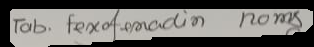

Output : Tab. fexofonadin 10mg

Processing image: 636_1717927117.7192466.png


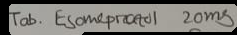

Output : Tab. Esomeprazol 20mg

Processing image: 605_1717927157.9089653.png


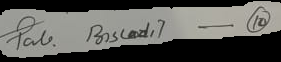

Output : Tab Roslazil

Processing image: 603_1717926848.4420729.png


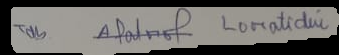

Output : TabAlofof Loratidine

Processing image: 582_1717926414.012089.png


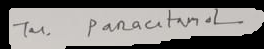

Output : Tab, Paracatrol

Processing image: 498_1717926867.420533.png


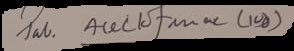

Output : Tab Acet/framac (1mg)

Processing image: 623_1717925854.428078.png


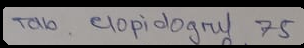

Output : Tab. clopidogru 75

Processing image: 629_1717926209.6953514.png


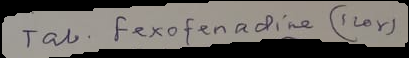

Output : Tab Fexofenadine (100mg)

Processing image: 625_1717926731.679847.png


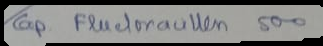

Output : Cap Frucloracullen 50

Processing image: 557_1717926489.3653853.png


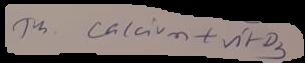

Output : Tab. Calcium 0/2

Processing image: 611_1717926000.0233598.png


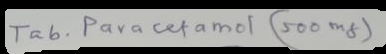

Output : Tab. Paracetamol (500mg)

Processing image: 623_1717925666.4994988.png


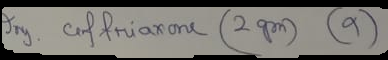

Output : Jy. cefrinazone (2 g)

Processing image: 599_1717925550.4129117.png


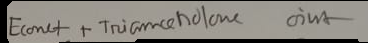

Output : Fomt + Tioimetelone oint

Processing image: 607_1717926569.4796178.png


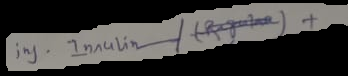

Output : Inj. Inaulin/

Processing image: 594_1717925555.5395334.png


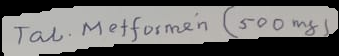

Output : Tab. Metfosmen (500mg)

Processing image: 593_1717926072.8462396.png


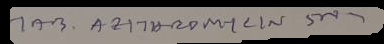

Output : 10. A21B-20M/CIN 5mg

Processing image: 586_1717926569.4781535.png


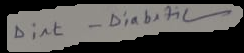

Output : DIAE - Diabatic

Processing image: 571_1717926867.4218895.png


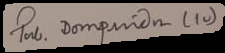

Output : Tab. Dompnien (10)

Processing image: 590_1717926915.344171.png


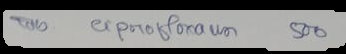

Output : TabCaproflorum 500

Processing image: 552_1717927157.9077752.png


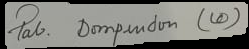

Output : Tab. Dompandon (10)

Processing image: 473_1717927157.9065778.png


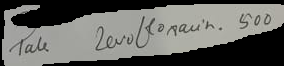

Output : TabZovl/loxacin. 500

Processing image: 1303_1717925886.7649713.png


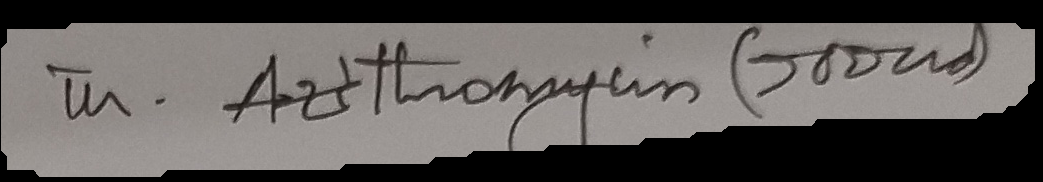

Output : Tab Azthroxen (500mg)

Processing image: 1317_1717925634.5221267.png


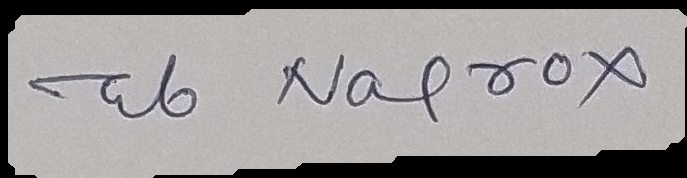

Output : Tab naprox

Processing image: 1315_1717927037.706807.png


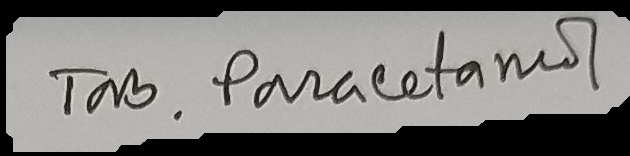

Output : Tab Paracetamol

Processing image: 1312_1717926439.1748781.png


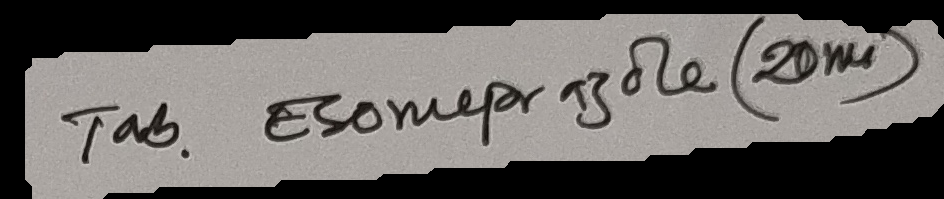

Output : Tab Esomeprazole (20mg)

Processing image: 1310_1717925892.8028197.png


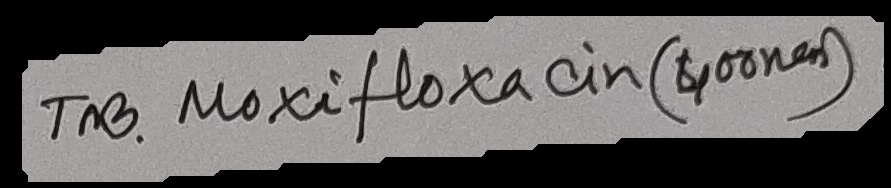

Output : Tab Moxifloxacin (500mg)

Processing image: 1291_1717927152.1642902.png


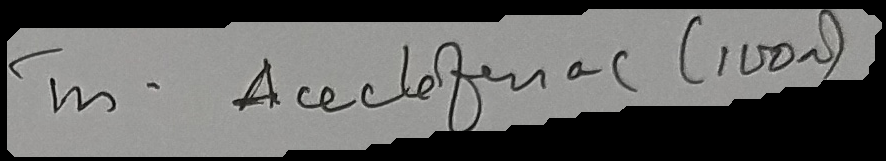

Output : In Aceclofenac (100mg)

Processing image: 1288_1717925848.4401126.png


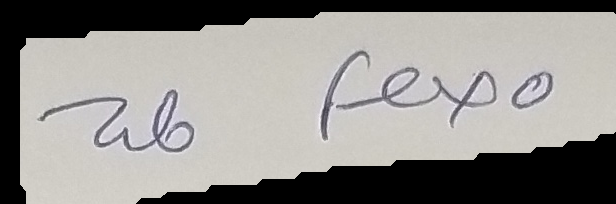

Output : Tab Fexo

Processing image: 1283_1717926779.852961.png


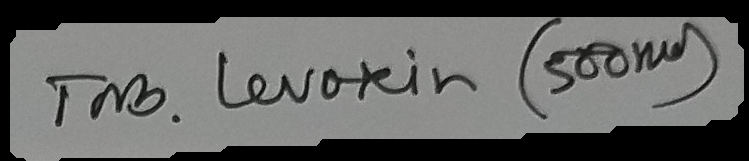

Output : Tab Levoxin (500mg)

Processing image: 1280_1717926449.0249984.png


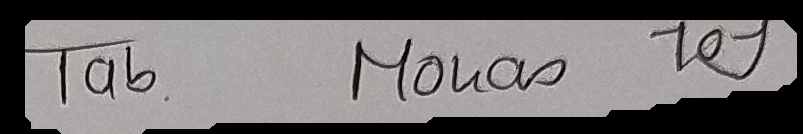

Output : Tab Mouac Tot

Processing image: 1280_1717926349.0144916.png


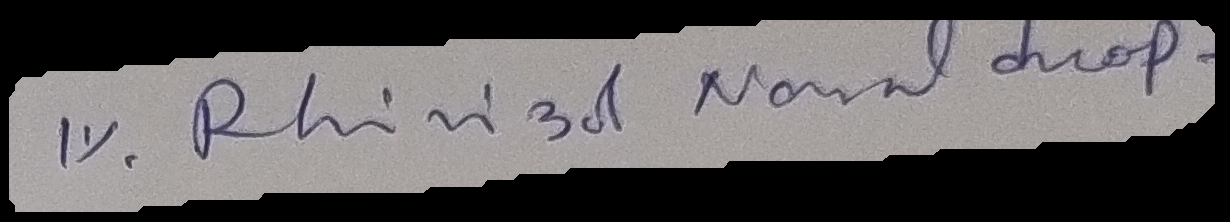

Output : 1% Rhinid normal drop

Processing image: 738_1717927117.7244437.png


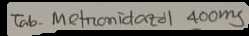

Output : Tab. Metamidazol 400mg

Processing image: 738_1717925972.3076987.png


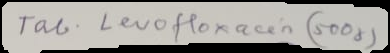

Output : Tab. Lavofloxacin (500g)

Processing image: 732_1717926600.643663.png


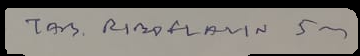

Output : Tab. RINOTLAVIN 5mg

Processing image: 723_1717925577.786194.png


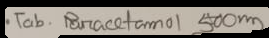

Output : Tab. Paracetamol 500mg

Processing image: 703_1717927070.2054348.png


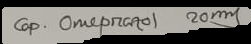

Output : Cap. Omeprazol 20mg

Processing image: 731_1717926879.418011.png


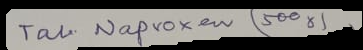

Output : Tab Naproxen (500)

Processing image: 727_1717927025.0694938.png


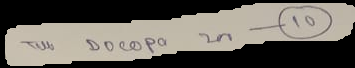

Output : TUB DOCOPA 20 (10)

Processing image: 728_1717925555.542475.png


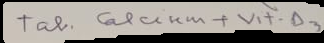

Output : Tab. Calcium + Vitamin D

Processing image: 699_1717926426.0024395.png


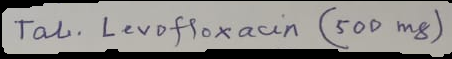

Output : Tab. Levofloxacin (500mg)

Processing image: 698_1717926806.9970663.png


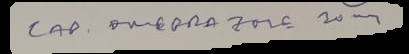

Output : CAP omeprazone 20mg

Processing image: 711_1717927068.538317.png


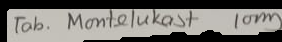

Output : Tab. Montelukast (10mg)

Processing image: 699_1717926209.6979115.png


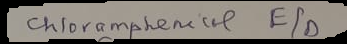

Output : chloramphenic F/0

Processing image: 680_1717925550.4143455.png


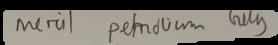

Output : metrol perndium (10mg)

Processing image: 672_1717925962.8403285.png


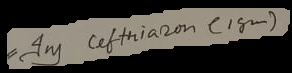

Output : Incy cefthiaron (150mg)

Processing image: 689_1717926000.025005.png


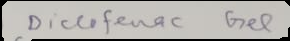

Output : Dicofenac

Processing image: 680_1717926072.847762.png


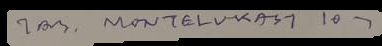

Output : 10S, MONTELVOS1 10

Processing image: 690_1717927117.7217827.png


Output : Tab. Domppercidon 10mg

Processing image: 666_1717925555.5410624.png


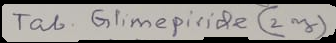

Output : Tab. Glimepicide (2mg)

Processing image: 666_1717925972.3059292.png


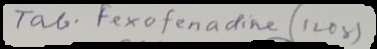

Output : Tab Fexofenadine (120mg)

Processing image: 660_1717926489.3665304.png


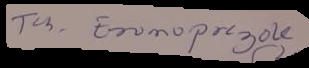

Output : Tab. Enemoprazole

Processing image: 671_1717925560.856201.png


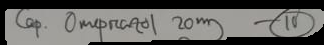

Output : Cap. omeprazol 20mg -10

Processing image: 664_1717926879.416176.png


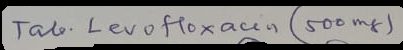

Output : Tab. Levofloxacin (500mg)

Processing image: 662_1717925551.9930944.png


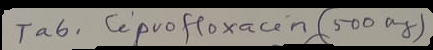

Output : Tab. Ciprofloxacin (500mg)

Processing image: 658_1717925577.7835588.png


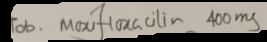

Output : Tab. Moutfozacolin 400mg

Processing image: 641_1717926867.4230368.png


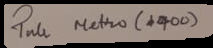

Output : Tab Metro (500)

Processing image: 657_1717926803.6243684.png


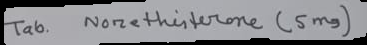

Output : Tab Norethierone (5mg)

Processing image: 637_1717926279.4603393.png


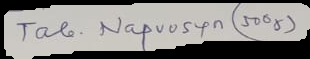

Output : Tab. Naproxen (500g)

Processing image: 651_1717926040.921721.png


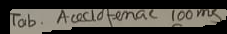

Output : Tab. ACACLOFEMAS (100MG)

Processing image: 652_1717926958.4941936.png


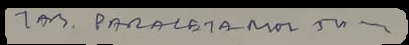

Output : 1M. PALALETAMOL

Processing image: 785_1717925574.4258811.png


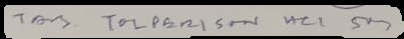

Output : Tab TOLPAZ/50ml WCL 5

Processing image: 784_1717926569.4828024.png


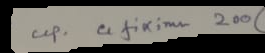

Output : cap. caffeine 200

Processing image: 783_1717926426.0042872.png


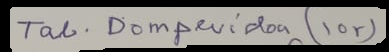

Output : Tab. Domperidin (10mg)

Processing image: 781_1717927026.9029589.png


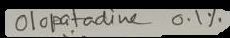

Output : Olofpatadine 0.1%

Processing image: 762_1717926040.9269722.png


Output : Tab. Tolpercin 50mg

Processing image: 761_1717925962.841775.png


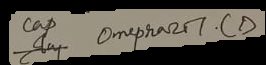

Output : cap omeprazol (CD)

Processing image: 763_1717925550.4156091.png


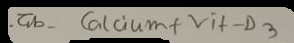

Output : Tab. Calcium Vit-D3

Processing image: 762_1717927070.2097595.png


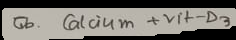

Output : Tab. (Alcium +vit-Da)

Processing image: 765_1717925666.5013354.png


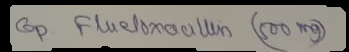

Output : Cap Flueloxaculin (100mg)

Processing image: 759_1717926414.0148163.png


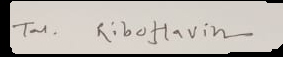

Output : Tab.ribotlavin

Processing image: 754_1717927070.2081926.png


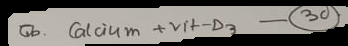

Output : Tab. (Alcium +vit-Dg - (30)

Processing image: 745_1717926731.681408.png


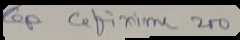

Output : Cofrinine 200

Processing image: 747_1717927025.0713797.png


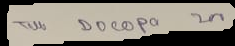

Output : Tab doopa

Processing image: 753_1717926869.1863856.png


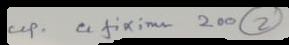

Output : cap. cifine 200 (2)

Processing image: 739_1717926279.4618673.png


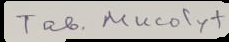

Output : Tab. Mucolyit

Processing image: 741_1717925645.2288585.png


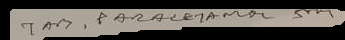

Output : PARACEMOL 5/1

Processing image: 742_1717927117.7261586.png


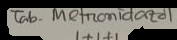

Output : Tab- Metromidcard

Processing image: 739_1717925560.8576446.png


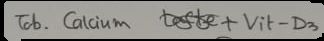

Output : Tab. Calcium Toste+Vit-Dz

Processing image: 744_1717926915.3470483.png


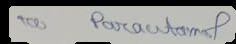

Output : Poracetamol



In [1]:
import os
from transformers import AutoProcessor, AutoModelForCausalLM, AutoConfig
import torch
from PIL import Image
from IPython.display import display  # To display images

# Determine the device and dtype
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load and modify configuration
config_path = "/content/drive/MyDrive/Florence"
config = AutoConfig.from_pretrained(config_path, trust_remote_code=True)

# Ensure vision_config is set for DaViT and manually set it
if hasattr(config, 'vision_config'):
    config.vision_config.model_type = 'davit'  # Manually set model type to DaViT
else:
    # If vision_config doesn't exist, initialize it
    config.vision_config = {
        "model_type": "davit",
        # Add any other vision configuration settings here if necessary
    }

# Save the modified configuration
config.save_pretrained(config_path)

# Load the model and processor with the modified config
model = AutoModelForCausalLM.from_pretrained(config_path, config=config, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(config_path, trust_remote_code=True)

# Define the folder containing images
image_folder = "/content/drive/MyDrive/Alamin"  # Replace with your actual folder path

# Loop through each image in the folder
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Only process image files
        image_path = os.path.join(image_folder, image_file)
        print(f"Processing image: {image_file}")

        # Load the image
        image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

        # Display the image
        display(image)

        # Define the prompt
        prompt = "<OCR>"

        # Process the inputs
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

        # Generate text
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=128,
            do_sample=False,
            num_beams=3
        )

        # Decode and post-process the generated text
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(generated_text, task="<OCR>", image_size=(image.width, image.height))

        # Print the result for this image
        print(f"Output : {parsed_answer['<OCR>']}\n")


In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM, AutoConfig
import torch
from PIL import Image

# Determine the device and dtype
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load and modify configuration
config_path = "/content/drive/MyDrive/Florence"
config = AutoConfig.from_pretrained(config_path, trust_remote_code=True)

# Ensure vision_config is set for DaViT and manually set it
if hasattr(config, 'vision_config'):
    config.vision_config.model_type = 'davit'  # Manually set model type to DaViT
else:
    # If vision_config doesn't exist, initialize it
    config.vision_config = {
        "model_type": "davit",
        # Add any other vision configuration settings here if necessary
    }

# Save the modified configuration
config.save_pretrained(config_path)

# Load the model and processor with the modified config
model = AutoModelForCausalLM.from_pretrained(config_path, config=config, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(config_path, trust_remote_code=True)

# Define the prompt and load the image
prompt = "<OCR_with_Region>"
image = Image.open("/content/bikas (9).jpg").convert("RGB")  # Ensure the image is in RGB format

# Process the inputs
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

# Generate text
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

# Decode and post-process the generated text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = processor.post_process_generation(generated_text, task="<OCR_with_Region>", image_size=(image.width, image.height))

# Print the result
print(parsed_answer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'<OCR_with_Region>': '20/1st'}
